# 03 - Révision des Statistiques : L'Équation la Plus Dangereuse

Dans son célèbre article de 2007, Howard Wainer parle d'équations très dangereuses :

"Certaines équations sont dangereuses si vous les connaissez, et d'autres sont dangereuses si vous ne les connaissez pas. La première catégorie peut représenter un danger car les secrets qu'elles renferment ouvrent des portes derrière lesquelles se cache un péril terrible. Le gagnant évident dans ce domaine est l'équation emblématique d'Einstein $E = mc^2$, car elle fournit une mesure de l'énorme énergie cachée dans la matière ordinaire. \[...\] Au lieu de cela, je m'intéresse aux équations qui libèrent leur danger non pas quand nous les connaissons, mais plutôt quand nous ne les connaissons pas. Gardées à portée de main, ces équations nous permettent de comprendre les choses clairement, mais leur absence nous laisse dangereusement ignorants."

L'équation dont il parle est l'équation de Moivre :

$
SE = \dfrac{\sigma}{\sqrt{n}} 
$

où $SE$ est l'erreur standard de la moyenne, $\sigma$ est l'écart-type, et $n$ est la taille de l'échantillon. Cela ressemble à un morceau de mathématiques que les braves et les vrais devraient maîtriser, alors passons-y.

Pour voir pourquoi ne pas connaître cette équation est très dangereux, examinons quelques données sur l'éducation. J'ai compilé des données sur les scores ENEM (scores standardisés des lycées brésiliens, similaires au SAT) de différentes écoles sur 3 ans. J'ai également nettoyé les données pour ne conserver que les informations pertinentes pour nous. Les données originales peuvent être téléchargées sur le [site de l'Inep](http://portal.inep.gov.br/web/guest/microdados#).

Si nous regardons l'école avec les meilleures performances, quelque chose attire l'attention : ces écoles ont un nombre relativement petit d'élèves.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

In [2]:
df = pd.read_csv("./data/enem_scores.csv")
df.sort_values(by="avg_score", ascending=False).head(10)

,year,school_id,number_of_students,avg_score
16670,2007,33062633,68,82.97
16796,2007,33065403,172,82.04
16668,2005,33062633,59,81.89
16794,2005,33065403,177,81.66
10043,2007,29342880,43,80.32
18121,2007,33152314,14,79.82
16781,2007,33065250,80,79.67
3026,2007,22025740,144,79.52
14636,2007,31311723,222,79.41
17318,2007,33087679,210,79.38


Looking at it from another angle, we can separate only the 1% of top schools and study them. What are they like? Perhaps we can learn something from the best and replicate it elsewhere. And sure enough, if we look at the top 1% of schools, we figure out they have, on average, fewer students.

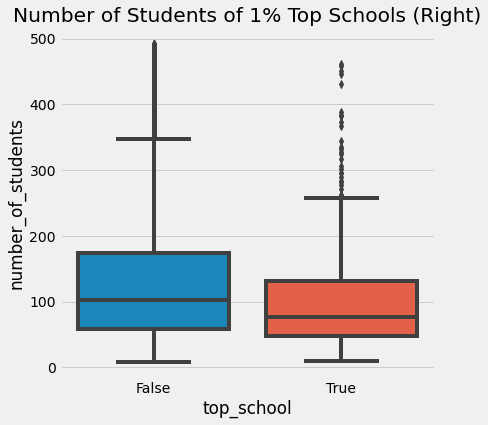

In [3]:
plot_data = (df
             .assign(top_school = df["avg_score"] >= np.quantile(df["avg_score"], .99))
             [["top_school", "number_of_students"]]
             .query(f"number_of_students<{np.quantile(df['number_of_students'], .98)}")) # remove outliers

plt.figure(figsize=(6,6))
sns.boxplot(x="top_school", y="number_of_students", data=plot_data)
plt.title("Number of Students of 1% Top Schools (Right)");

Une conclusion naturelle est que les petites écoles conduisent à de meilleures performances académiques. Cela semble intuitivement logique, car nous croyons que moins d'élèves par enseignant permettent à l'enseignant de donner une attention plus ciblée à chaque élève. Mais quel est le rapport avec l'équation de Moivre ? Et pourquoi est-elle dangereuse ?

Eh bien, elle devient dangereuse une fois que les gens commencent à prendre des décisions importantes et coûteuses basées sur cette information. Dans son article, Howard continue :

"Dans les années 1990, il est devenu populaire de défendre la réduction de la taille des écoles. De nombreuses organisations philanthropiques et agences gouvernementales ont financé la division des grandes écoles parce que les élèves des petites écoles sont surreprésentés dans les groupes ayant de bons résultats aux tests."

Ce que les gens ont oublié de faire, c'est de regarder également le bas des 1% des écoles. Si nous le faisons, surprise ! Elles ont aussi très peu d'élèves !

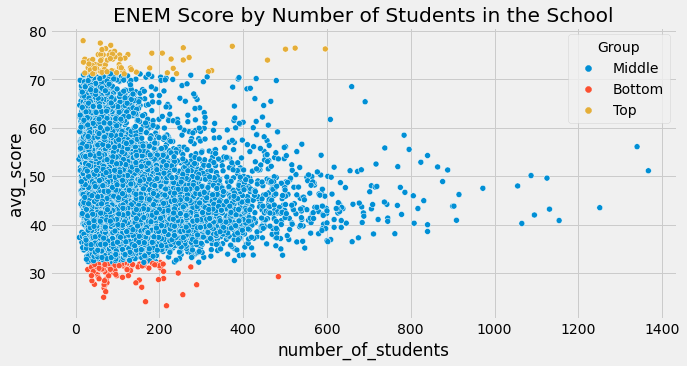

In [4]:
q_99 = np.quantile(df["avg_score"], .99)
q_01 = np.quantile(df["avg_score"], .01)

plot_data = (df
             .sample(10000)
             .assign(Group = lambda d: np.select([d["avg_score"] > q_99, d["avg_score"] < q_01],
                                                 ["Top", "Bottom"], "Middle")))
plt.figure(figsize=(10,5))
sns.scatterplot(y="avg_score", x="number_of_students", hue="Group", data=plot_data)
plt.title("ENEM Score by Number of Students in the School");

Nous voyons ci-dessus précisément ce qui est attendu selon l'équation de Moivre. À mesure que le nombre d'élèves augmente, le score moyen devient de plus en plus précis. Les écoles avec très peu d'élèves peuvent avoir des scores très élevés et très bas simplement par hasard. Cela est moins probable dans les grandes écoles. L'équation de Moivre parle d'un fait fondamental concernant la réalité de l'information et des enregistrements sous forme de données : elle est toujours imprécise. La question devient alors de savoir à quel point elle est inexacte.

Les statistiques sont la science qui traite de ces imprécisions afin qu'elles ne nous prennent pas au dépourvu. Comme le dit Taleb dans son livre *Le Hasard Sauvage* :

> La probabilité n'est pas un simple calcul des chances sur les dés ou des variantes plus compliquées ; c'est l'acceptation du manque de certitude dans nos connaissances et le développement de méthodes pour gérer notre ignorance.

Une façon de quantifier notre incertitude est la **variance de nos estimations**. La variance nous indique à quel point une observation s'écarte de sa valeur centrale et la plus probable. Comme l'indique l'équation de Moivre, cette incertitude diminue à mesure que la quantité de données que nous observons augmente. Cela a du sens, n'est-ce pas ? Si nous voyons de nombreux élèves obtenir d'excellents résultats dans une école, nous pouvons être plus confiants que c'est effectivement une bonne école. Cependant, si nous voyons une école avec seulement 10 élèves et que 8 d'entre eux réussissent bien, nous devons être plus méfiants. Par hasard, il se pourrait que l'école ait eu quelques élèves au-dessus de la moyenne.

Le beau graphique triangulaire que nous voyons ci-dessus raconte précisément cette histoire. Il nous montre comment nos estimations des performances scolaires ont une grande variance lorsque la taille des échantillons est petite. Il indique également que la variance diminue à mesure que la taille de l'échantillon augmente. Cela est vrai pour le score moyen dans une école, mais c'est également vrai pour toute statistique résumée que nous avons, y compris l'ATE que nous voulons souvent estimer.

## L'erreur standard de nos estimations

Puisqu'il ne s'agit que d'une révision des statistiques, je vais me permettre d'aller un peu plus vite maintenant. Si vous n'êtes pas familier avec les distributions, la variance et les erreurs standards, veuillez lire attentivement, mais gardez à l'esprit que vous pourriez avoir besoin de ressources supplémentaires. Je vous suggère de chercher un cours du MIT sur l'introduction aux statistiques. Ils sont généralement très bons.

Dans la section précédente, nous avons estimé l'effet moyen du traitement $E[Y_1-Y_0]$ comme la différence des moyennes entre les traités et les non-traités $E[Y|T=1]-E[Y|T=0]$. Nous avons déterminé l'ATE pour les cours en ligne comme notre exemple motivant. Nous avons également observé un impact négatif ; les cours en ligne ont fait en sorte que les étudiants obtiennent environ 5 points de moins que les étudiants des cours en présentiel. Maintenant, nous allons voir si cet impact est statistiquement significatif.

Pour ce faire, nous devons estimer le $SE$. Nous avons déjà $n$, notre taille d'échantillon. Pour obtenir l'estimation de l'écart type, nous pouvons faire ce qui suit :

$$
\hat{\sigma}=\sqrt{\frac{1}{N-1}\sum_{i=1}^N (x_i-\bar{x})^2}
$$

où $\bar{x}$ est la moyenne de $x$. Heureusement pour nous, la plupart des logiciels de programmation implémentent déjà cela. Dans Pandas, nous pouvons utiliser la méthode [std](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.std.html).

In [5]:
data = pd.read_csv("./data/online_classroom.csv")
online = data.query("format_ol==1")["falsexam"]
face_to_face = data.query("format_ol==0 & format_blended==0")["falsexam"]

def se(y: pd.Series):
    return y.std() / np.sqrt(len(y))

print("SE for Online:", se(online))
print("SE for Face to Face:", se(face_to_face))

SE for Online: 1.5371593973041635
SE for Face to Face: 0.8723511456319106


## Intervalles de Confiance

L'erreur standard de notre estimation est une mesure de confiance. Nous devons plonger dans des eaux statistiques turbulentes et polémiques pour comprendre précisément ce que cela signifie. Selon une vision des statistiques, la vision fréquentiste, nous dirions que nos données ne sont rien de plus qu'une manifestation d'un processus de génération de données précis. Ce processus est abstrait et idéal. Il est régi par de vrais paramètres qui sont immuables mais aussi inconnus de nous. Dans le contexte des tests des élèves, si nous pouvions réaliser plusieurs expériences et collecter plusieurs ensembles de données, tous ressembleraient au véritable processus de génération de données sous-jacent mais ne seraient pas exactement identiques. Cela ressemble beaucoup aux écrits de Platon sur les Formes :

> Chacune [des formes essentielles] se manifeste dans une grande variété de combinaisons, avec des actions, avec des choses matérielles et les unes avec les autres, et chacune semble être multiple.

Supposons que nous ayons une véritable distribution abstraite des scores des tests des élèves pour mieux comprendre cela. Il s'agit d'une distribution normale avec une véritable moyenne de 74 et un véritable écart type de 2. À partir de cette distribution, nous pouvons réaliser 10 000 expériences. À chacune d'entre elles, nous collectons 500 échantillons. Si nous les traçons dans un histogramme, nous pouvons voir que les moyennes des expériences sont distribuées autour de la véritable moyenne. Certaines données expérimentales auront une moyenne inférieure à la véritable, et certaines seront supérieures.

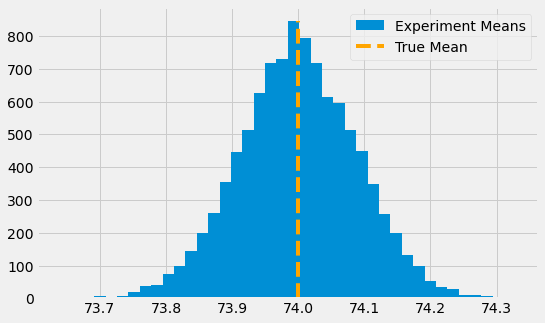

In [6]:
true_std = 2
true_mean = 74

n = 500
def run_experiment(): 
    return np.random.normal(true_mean,true_std, 500)

np.random.seed(42)

plt.figure(figsize=(8,5))
freq, bins, img = plt.hist([run_experiment().mean() for _ in range(10000)], bins=40, label="Experiment Means")
plt.vlines(true_mean, ymin=0, ymax=freq.max(), linestyles="dashed", label="True Mean", color="orange")
plt.legend();


Remarquez que nous parlons ici de la moyenne des moyennes. Par hasard, nous pourrions avoir un expériment où la moyenne est légèrement en dessous ou au-dessus de la véritable moyenne. Cela signifie que nous ne pouvons jamais être sûrs que la moyenne de notre expériment correspond à la moyenne vraie, platonicienne et idéale. Cependant, **avec l'erreur standard, nous pouvons créer un intervalle qui contiendra la véritable moyenne 95 % du temps**.

Dans la vie réelle, nous n'avons pas le luxe de simuler le même expériment avec plusieurs ensembles de données. Nous n'en avons souvent qu'un seul. Mais nous pouvons nous appuyer sur l'intuition ci-dessus pour construire ce que nous appelons des **intervalles de confiance**. Les intervalles de confiance sont accompagnés d'une probabilité qui leur est associée. La plus courante est de 95 %. Cette probabilité nous indique combien d'intervalles de confiance hypothétiques que nous construirions à partir d'études différentes contiendraient la véritable moyenne. Par exemple, les intervalles de confiance à 95 % calculés à partir d'études similaires incluraient la véritable moyenne 95 % du temps.

Pour calculer l'intervalle de confiance, nous utilisons le **théorème central limite**. Ce théorème stipule que **les moyennes des expériments sont normalement distribuées**. D'après la théorie statistique, nous savons que 95 % de la masse d'une distribution normale se situe entre 2 écarts-types au-dessus et en dessous de la moyenne. Techniquement, c'est 1,96, mais 2 est suffisamment proche.

![normal_density](./data/img/stats-review/normal_dist.jpeg)

L'erreur standard de la moyenne sert d'estimation de la distribution des moyennes des expériments. Ainsi, si nous la multiplions par 2 et l'ajoutons et la soustrayons de la moyenne de l'une de nos expériments, nous construirons un intervalle de confiance à 95 % pour la véritable moyenne.

In [7]:
np.random.seed(321)
exp_data = run_experiment()
exp_se = exp_data.std() / np.sqrt(len(exp_data))
exp_mu = exp_data.mean()
ci = (exp_mu - 2 * exp_se, exp_mu + 2 * exp_se)
print(ci)

(73.82718114045632, 74.17341543460314)


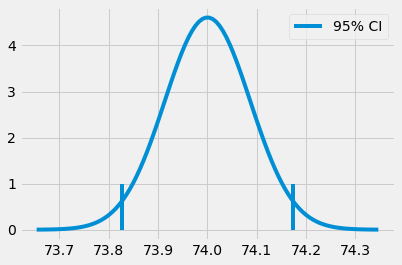

In [8]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="95% CI")
plt.legend()
plt.show()

Bien sûr, nous n’avons pas besoin de nous limiter à l’intervalle de confiance à 95 %. Nous pourrions générer l’intervalle à 99 % en trouvant par quel facteur nous devons multiplier l’écart type pour que l’intervalle contienne 99 % de la masse d’une distribution normale.

La fonction `ppf` en Python nous donne l’inverse de la fonction de répartition cumulée (CDF). Au lieu de multiplier l’erreur standard par 2 comme nous l’avons fait pour trouver l’IC à 95 %, nous allons la multiplier par z, ce qui donnera l’IC à 99 %. Ainsi, `ppf(0.5)` retournera 0,0, indiquant que 50 % de la masse de la distribution normale standard (moyenne 0 et 1 écart type) est en dessous de 0,0. De la même manière, si nous utilisons 99,5 %, nous obtiendrons la valeur z telle que 99,5 % de la masse de la distribution se trouve en dessous de cette valeur. En d’autres termes, 0,5 % de la masse se trouve au-dessus de cette valeur.

In [9]:
from scipy import stats
z = stats.norm.ppf(.995)
print(z)
ci = (exp_mu - z * exp_se, exp_mu + z * exp_se)
ci

2.5758293035489004


(73.7773381773405, 74.22325839771896)

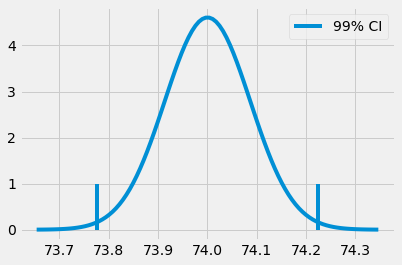

In [10]:
x = np.linspace(exp_mu - 4*exp_se, exp_mu + 4*exp_se, 100)
y = stats.norm.pdf(x, exp_mu, exp_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=1)
plt.vlines(ci[0], ymin=0, ymax=1, label="99% CI")
plt.legend()
plt.show()

Revenons à notre expériment en classe, nous pouvons construire l’intervalle de confiance pour le score moyen à l’examen pour les groupes d’étudiants en ligne et en présentiel.

In [11]:
def ci(y: pd.Series):
    return (y.mean() - 2 * se(y), y.mean() + 2 * se(y))

print("95% CI for Online:", ci(online))
print("95% for Face to Face:", ci(face_to_face))

95% CI for Online: (70.56094429049804, 76.7095818797147)
95% for Face to Face: (76.80278229206951, 80.29218687459715)


Nous pouvons voir que les IC à 95 % des groupes ne se chevauchent pas. L'extrémité inférieure de l'IC pour les cours en présentiel est au-dessus de l'extrémité supérieure de l'IC pour les cours en ligne. Cela prouve que notre résultat n'est pas dû au hasard et que la véritable moyenne pour les étudiants en cours présentiels est plus élevée que la véritable moyenne pour les étudiants en cours en ligne. En d'autres termes, il y a une diminution causale significative des performances académiques lorsque l'on passe des cours en présentiel aux cours en ligne.

Pour récapituler, les intervalles de confiance sont un moyen de placer l'incertitude autour de nos estimations. Plus la taille de l'échantillon est petite, plus l'erreur standard est grande, et plus l'intervalle de confiance est large. Comme ils sont super faciles à calculer, l'absence d'intervalles de confiance signale soit de mauvaises intentions, soit simplement un manque de connaissances, ce qui est tout aussi préoccupant. Enfin, vous devriez toujours être méfiant envers les mesures sans aucun indicateur d'incertitude.

![img](data/img/stats-review/ci_xkcd.png)

Un dernier mot de prudence ici. Les intervalles de confiance sont plus difficiles à interpréter qu'il n'y paraît. Par exemple, je **ne devrais pas** dire que cet intervalle de confiance particulier à 95 % contient la véritable moyenne de la population avec une probabilité de 95 %. Dans les statistiques fréquentistes qui utilisent des intervalles de confiance, la moyenne de la population est considérée comme une constante véritable de la population. Donc, elle est soit dans notre intervalle de confiance particulier, soit elle ne l'est pas. En d'autres termes, notre intervalle de confiance spécifique contient ou ne contient pas la véritable moyenne. Si c'est le cas, la probabilité de la contenir serait de 100 %, pas de 95 %. Si ce n'est pas le cas, la probabilité serait de 0 %. En revanche, dans les intervalles de confiance, les 95 % se réfèrent à la fréquence à laquelle de tels intervalles de confiance, calculés dans de nombreuses études, contiennent la véritable moyenne. Les 95 % représentent notre confiance dans l'algorithme utilisé pour calculer l'IC à 95 %, et non dans l'intervalle particulier lui-même.

Cela dit, en tant qu'économiste (statisticiens, veuillez détourner le regard maintenant), je pense que ce purisme n'est pas très utile. En pratique, vous verrez des gens dire que l'intervalle de confiance particulier contient la véritable moyenne 95 % du temps. Bien que ce soit faux, ce n'est pas très nuisible, car cela place toujours un degré précis d'incertitude dans nos estimations. De plus, si nous passons aux statistiques bayésiennes et utilisons des intervalles probables au lieu d'intervalles de confiance, nous pourrions dire que l'intervalle contient la moyenne de la distribution 95 % du temps. De plus, d'après ce que j'ai vu en pratique, avec des tailles d'échantillon décentes, les intervalles probables bayésiens sont plus similaires aux intervalles de confiance que les bayésiens et les fréquentistes ne voudraient l'admettre. Donc, si ma parole a une quelconque valeur, sentez-vous libre de dire ce que vous voulez sur votre intervalle de confiance. Je m'en fiche si vous dites qu'ils contiennent la véritable moyenne 95 % du temps. N'oubliez jamais de les placer autour de vos estimations ; sinon, vous aurez l'air ridicule.

## Tests d'Hypothèses

Une autre façon d'incorporer l'incertitude est d'énoncer un test d'hypothèse : la différence de moyennes est-elle statistiquement différente de zéro (ou de toute autre valeur) ? Nous nous rappellerons que la somme ou la différence de deux distributions normales indépendantes est également une distribution normale. La moyenne résultante sera la somme ou la différence entre les deux distributions, tandis que la variance sera toujours la somme des variances :

$
N(\mu_1, \sigma_1^2) - N(\mu_2, \sigma_2^2) = N(\mu_1 - \mu_2, \sigma_1^2 + \sigma_2^2)
$

$
N(\mu_1, \sigma_1^2) + N(\mu_2, \sigma_2^2) = N(\mu_1 + \mu_2, \sigma_1^2 + \sigma_2^2)
$

Si vous ne vous en souvenez pas, ce n'est pas grave. Nous pouvons toujours utiliser le code et les données simulées pour vérifier :

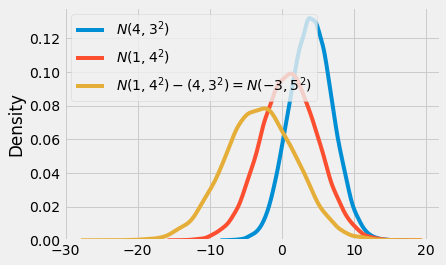

In [12]:
np.random.seed(123)
n1 = np.random.normal(4, 3, 30000)
n2 = np.random.normal(1, 4, 30000)
n_diff = n2 - n1
sns.distplot(n1, hist=False, label="$N(4,3^2)$")
sns.distplot(n2, hist=False, label="$N(1,4^2)$")
sns.distplot(n_diff, hist=False, label=f"$N(1,4^2) - (4,3^2) = N(-3, 5^2)$")
plt.legend()
plt.show()

Si nous prenons la distribution des moyennes de nos 2 groupes et soustrayons l’une de l’autre, nous obtiendrons une troisième distribution. La moyenne de cette distribution finale sera la différence des moyennes, et l’écart type de cette distribution sera la racine carrée de la somme des écarts types.

$
\mu_{diff} = \mu_1 - \mu_2
$

$
SE_{diff} = \sqrt{SE^2_1 + SE^2_2} = \sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}
$

Revenons à notre exemple de classe. Nous allons construire cette distribution de la différence. Bien sûr, une fois que nous l’avons, la construction de l’IC à 95 % est simple.

In [13]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
ci = (diff_mu - 1.96*diff_se, diff_mu + 1.96*diff_se)
print(ci)

(-8.376410208363385, -1.4480327880905248)


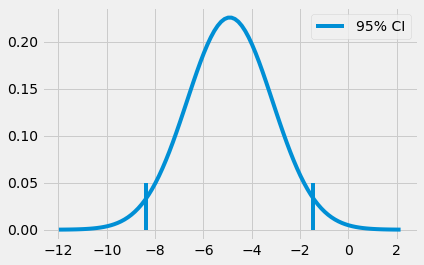

In [14]:
x = np.linspace(diff_mu - 4*diff_se, diff_mu + 4*diff_se, 100)
y = stats.norm.pdf(x, diff_mu, diff_se)
plt.plot(x, y)
plt.vlines(ci[1], ymin=0, ymax=.05)
plt.vlines(ci[0], ymin=0, ymax=.05, label="95% CI")
plt.legend()
plt.show()

Avec ces informations, nous pouvons dire que nous sommes confiants à 95 % que la véritable différence entre les groupes en ligne et en présentiel se situe entre -8,37 et -1,44. Nous pouvons également construire un statistique z en divisant la différence de moyenne par l’erreur standard des différences.

$
z = \dfrac{\mu_{diff} - H_{0}}{SE_{diff}} = \dfrac{(\mu_1 - \mu_2) - H_{0}}{\sqrt{\sigma_1^2/n_1 + \sigma_2^2/n_2}}
$

Où $H_0$ est la valeur contre laquelle nous voulons tester notre différence.

Le statistique z est une mesure de l’extrémisme de la différence observée. Nous allons utiliser la contradiction pour tester notre hypothèse que la différence des moyennes est statistiquement différente de zéro. Nous allons supposer que l’opposé est vrai ; nous allons supposer que la différence est nulle. C’est ce qu’on appelle une hypothèse nulle, ou $H_0$. Ensuite, nous nous demanderons : “Est-il probable que nous observions une telle différence si la véritable différence était nulle ?” Nous pouvons traduire cette question en vérifiant à quelle distance de zéro se trouve notre statistique z en termes mathématiques statistiques.

Sous $H_0$, le statistique z suit une distribution normale standard. Donc, si la différence est effectivement nulle, nous verrions le statistique z dans les 2 écarts types de la moyenne 95 % du temps. La conséquence directe est que si z tombe au-dessus ou en dessous de 2 écarts types, nous pouvons rejeter l’hypothèse nulle avec une confiance de 95 %.

Voyons à quoi cela ressemble dans notre exemple.

In [15]:
z = diff_mu / diff_se
print(z)

-2.7792810791031224


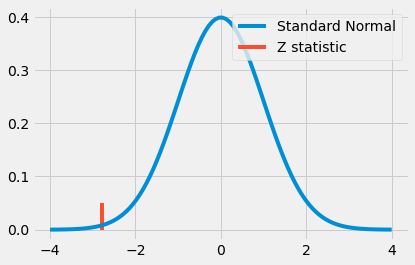

In [16]:
x = np.linspace(-4,4,100)
y = stats.norm.pdf(x, 0, 1)
plt.plot(x, y, label="Standard Normal")
plt.vlines(z, ymin=0, ymax=.05, label="Z statistic", color="C1")
plt.legend()
plt.show()

Cela semble être une valeur assez extrême. En effet, elle est supérieure à 2, ce qui signifie qu’il y a moins de 5 % de chances que nous observions une valeur aussi extrême s’il n’y avait pas de différence entre les groupes. Cela nous conduit encore une fois à conclure que passer des cours en présentiel aux cours en ligne entraîne une baisse statistiquement significative des performances académiques.

Une dernière chose intéressante à propos des tests d’hypothèses est qu’ils sont moins conservateurs que de vérifier si les intervalles de confiance à 95 % des groupes traités et non traités se chevauchent. En d’autres termes, si les intervalles de confiance des deux groupes se chevauchent, il peut encore être le cas que le résultat soit statistiquement significatif. Par exemple, supposons que le groupe en présentiel ait un score moyen de 80 avec une erreur standard de 4, et que le groupe en ligne ait un score moyen de 71 avec une erreur standard de 2.

In [17]:
cont_mu, cont_se =  (71, 2)
test_mu, test_se = (80, 4)

diff_mu = test_mu - cont_mu
diff_se = np.sqrt(cont_se**2 + test_se**2)

print("Control 95% CI:", (cont_mu-1.96*cont_se, cont_mu+1.96*cont_se))
print("Test 95% CI:", (test_mu-1.96*test_se, test_mu+1.96*test_se))
print("Diff 95% CI:", (diff_mu-1.96*diff_se, diff_mu+1.96*diff_se))

Control 95% CI: (67.08, 74.92)
Test 95% CI: (72.16, 87.84)
Diff 95% CI: (0.23461352820082482, 17.765386471799175)


Si nous construisons les intervalles de confiance pour ces groupes, ils se chevauchent. La limite supérieure de l'IC à 95 % pour le groupe en ligne est de 74,92, et la limite inférieure pour le groupe en présentiel est de 72,16. Cependant, une fois que nous calculons l'intervalle de confiance à 95 % pour la différence entre les groupes, nous pouvons voir qu'il ne contient pas zéro. Même si les intervalles de confiance individuels se chevauchent, la différence peut encore être statistiquement différente de zéro.

## Les p-values

Précédemment, j'ai dit qu'il y avait moins de 5 % de chances que nous observions une valeur aussi extrême si la différence entre les groupes en ligne et en présentiel était effectivement nulle. Mais pouvons-nous estimer précisément quelle est cette probabilité ? Quelle est la probabilité que nous observions une valeur aussi extrême ? C'est là qu'interviennent les p-values !

Comme avec les intervalles de confiance (et la plupart des statistiques fréquentistes, en fait), la véritable définition des p-values peut être très déroutante. Donc, pour ne prendre aucun risque, je vais copier la définition de Wikipédia : "la p-value est la probabilité d'obtenir des résultats de test au moins aussi extrêmes que les résultats effectivement observés pendant le test, en supposant que l'hypothèse nulle est correcte".

Pour être plus succinct, la p-value est la probabilité de voir de telles données, étant donné que l'hypothèse nulle est vraie. Elle mesure à quel point il est improbable que vous voyiez une mesure si l'hypothèse nulle est vraie. Naturellement, cela est souvent confondu avec la probabilité que l'hypothèse nulle soit vraie. Notez la différence ici. La p-value n'est PAS $P(H_0|data)$, mais plutôt $P(data|H_0)$.

Mais ne laissez pas cette complexité vous tromper. En termes pratiques, elles sont assez simples à utiliser.

![p_value](./data/img/stats-review/p_value.png)

Pour obtenir la p-value, nous devons calculer l'aire sous la distribution normale standard avant ou après le statistique z. Heureusement, nous avons un ordinateur pour faire ce calcul pour nous. Nous pouvons simplement brancher le statistique z dans la CDF de la distribution normale standard.

In [18]:
print("P-value:", stats.norm.cdf(z))

P-value: 0.0027239680835563383


Remarquez à quel point la p-value est intéressante car elle nous évite d'avoir à spécifier un niveau de confiance, comme 95 % ou 99 %. Mais, si nous souhaitons en rapporter un, à partir de la p-value, nous savons précisément à quel niveau de confiance notre test passera ou échouera. Par exemple, avec une p-value de 0,0027, nous voyons que nous avons une signification jusqu'au niveau de 0,2 %. Ainsi, bien que l'IC à 95 % et l'IC à 99 % pour la différence ne contiendront pas zéro, l'IC à 99,9 % le fera. Cela signifie qu'il n'y a qu'une probabilité de 0,2 % d'observer ce statistique z extrême si la différence était nulle.

In [19]:
diff_mu = online.mean() - face_to_face.mean()
diff_se = np.sqrt(face_to_face.var()/len(face_to_face) + online.var()/len(online))
print("95% CI:", (diff_mu - stats.norm.ppf(.975)*diff_se, diff_mu + stats.norm.ppf(.975)*diff_se))
print("99% CI:", (diff_mu - stats.norm.ppf(.995)*diff_se, diff_mu + stats.norm.ppf(.995)*diff_se))
print("99.9% CI:", (diff_mu - stats.norm.ppf(.9995)*diff_se, diff_mu + stats.norm.ppf(.9995)*diff_se))

95% CI: (-8.376346553082909, -1.4480964433710017)
99% CI: (-9.46485353526404, -0.3595894611898709)
99.9% CI: (-10.728040658245558, 0.9035976617916459)


## Idées Clés

Nous avons vu à quel point il est important de connaître l'équation de Moivre et nous l'avons utilisée pour placer un degré de certitude autour de nos estimations. Plus précisément, nous avons déterminé que les cours en ligne entraînent une diminution des performances académiques par rapport aux cours en présentiel. Nous avons également vu que c'était un résultat statistiquement significatif. Nous l'avons fait en comparant les intervalles de confiance des moyennes des deux groupes, en regardant l'intervalle de confiance pour la différence, en faisant un test d'hypothèse et en regardant la p-value. Résumons tout cela dans une seule fonction qui permet de faire une comparaison A/B comme celle que nous avons faite ci-dessus.

In [20]:
def AB_test(test: pd.Series, control: pd.Series, confidence=0.95, h0=0):
    mu1, mu2 = test.mean(), control.mean()
    se1, se2 = test.std() / np.sqrt(len(test)), control.std() / np.sqrt(len(control))
    
    diff = mu1 - mu2
    se_diff = np.sqrt(test.var()/len(test) + control.var()/len(control))
    
    z_stats = (diff-h0)/se_diff
    p_value = stats.norm.cdf(z_stats)
    
    def critial(se): return -se*stats.norm.ppf((1 - confidence)/2)
    
    print(f"Test {confidence*100}% CI: {mu1} +- {critial(se1)}")
    print(f"Control {confidence*100}% CI: {mu2} +- {critial(se2)}")
    print(f"Test-Control {confidence*100}% CI: {diff} +- {critial(se_diff)}")
    print(f"Z Statistic {z_stats}")
    print(f"P-Value {p_value}")
        
AB_test(online, face_to_face)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.7792810791031224
P-Value 0.0027239680835563383


Étant donné que notre fonction est suffisamment générique, nous pouvons tester d'autres hypothèses nulles. Par exemple, pouvons-nous essayer de rejeter l'hypothèse selon laquelle la différence de performance entre les cours en ligne et les cours en présentiel est de -1 ? Avec les résultats que nous obtenons, nous pouvons dire avec une confiance de 95 % que la différence est plus importante que -1. Mais nous ne pouvons pas le dire avec une confiance de 99 % :

In [21]:
AB_test(online, face_to_face, h0=-1)

Test 95.0% CI: 73.63526308510637 +- 3.0127770572134565
Control 95.0% CI: 78.54748458333333 +- 1.7097768273108005
Test-Control 95.0% CI: -4.912221498226955 +- 3.4641250548559537
Z Statistic -2.2134920404560883
P-Value 0.013431870694630114


## Références

J'aime penser à ce livre entier comme un hommage à Joshua Angrist, Alberto Abadie et Christopher Walters pour leur incroyable cours d'économétrie. La plupart des idées ici sont tirées de leurs cours à l'American Economic Association. Les regarder est ce qui me maintient sain d'esprit pendant cette année difficile de 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

Je tiens également à référencer les livres incroyables d'Angrist. Ils m'ont montré que l'économétrie, ou 'Metrics' comme ils l'appellent, n'est pas seulement extrêmement utile mais aussi profondément amusante.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

Ma dernière référence est le livre de Miguel Hernan et Jamie Robins. Il a été mon compagnon fidèle dans les questions causales les plus épineuses que j'ai dû résoudre.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

Les données utilisées ici proviennent d'une étude de Alpert, William T., Kenneth A. Couch, et Oskar R. Harmon. 2016. ["A Randomized Assessment of Online Learning"](https://www.aeaweb.org/articles?id=10.1257/aer.p20161057). American Economic Review, 106 (5): 378-82.

![img](./data/img/poetry.png)

## Contribuer

*L'Inférence Causale pour les Courageux et les Vrais* est un matériel open-source sur l'inférence causale, la statistique de la science. Son objectif est d'être accessible monétairement et intellectuellement. Il utilise uniquement des logiciels gratuits basés sur Python.
Si vous avez trouvé ce livre précieux et souhaitez le soutenir, veuillez vous rendre sur [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). Si vous n'êtes pas prêt à contribuer financièrement, vous pouvez également aider en corrigeant les fautes de frappe, en suggérant des modifications ou en donnant votre avis sur les passages que vous n'avez pas compris. Rendez-vous sur le repo du livre et [ouvrez une issue](https://github.com/matheusfacure/python-causality-handbook/issues). Enfin, si vous avez aimé ce contenu, veuillez le partager avec d'autres personnes qui pourraient le trouver utile et lui donner une [étoile sur GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).